In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

sns.set_theme()

In [2]:
# Read data
train = pd.read_csv('Data/train.csv')
validation = pd.read_csv('Data/test.csv')

# Display relevant information about the data
rows = train.shape[0] + validation.shape[0]
columns = train.shape[1]
train_prop = round((train.shape[0] / rows * 100), 1)
validation_prop = round((validation.shape[0] / rows * 100), 1)

string = f"The data has {rows} observations and {columns} variables.\n" \
         f"The train and validation proportion of the entire data is {train_prop}% and {validation_prop}%, respectively.\n"
print(string)

# Take a look at the data
train.head(3)


The data has 2919 observations and 81 variables.
The train and validation proportion of the entire data is 50.0% and 50.0%, respectively.



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
# Identifying variable types and NaN presence
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# Cleaning variables with more than 20% of NaN values and removing id col
na_limit = train.shape[0] * 0.2
cols_not_na = (train.isna().sum() <= na_limit)

cols_removed = train.columns[~cols_not_na].values
print('Columns removed because of too many NaN entries:\n{cols}'.format(cols=cols_removed))

train = train.loc[:, cols_not_na]
validation = validation.loc[:, cols_not_na[:-1]]

train.drop('Id', axis=1, inplace=True)

Columns removed because of too many NaN entries:
['LotFrontage' 'Alley' 'MasVnrType' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' 'GarageFinish' 'GarageQual' 'GarageCond' 'PoolQC' 'Fence'
 'MiscFeature']


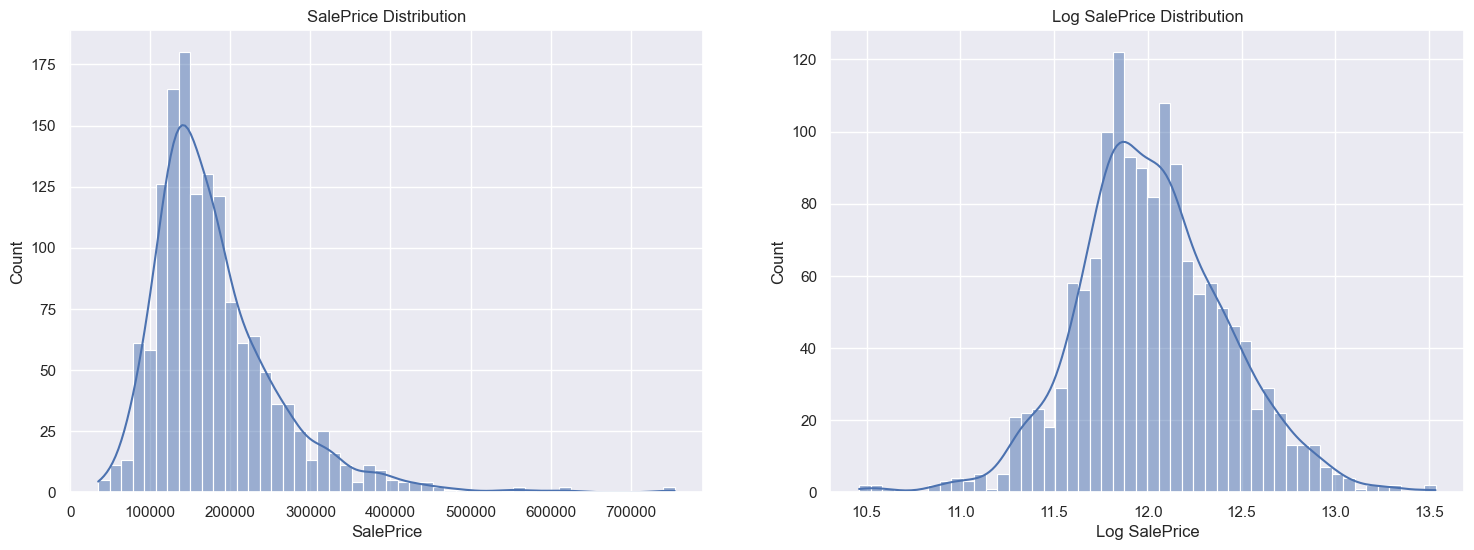

In [5]:
# Plotting SalePrice and log of SalePrice - because of skewness

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
bins = 50

# Raw price distribution
sns.histplot(train['SalePrice'], ax=axes[0], bins=bins, kde=True)
axes[0].set_title('SalePrice Distribution')

# Log price distribution
sns.histplot(np.log(train['SalePrice']), ax=axes[1], bins=bins, kde=True)
axes[1].set_title('Log SalePrice Distribution')
axes[1].set_xlabel('Log SalePrice')

plt.show()


#### If we need to use traditional statistical models, it is possible to normalize the distribution by applying the log transformation. However, we need to be careful because this transformation can eliminate non-linear relationships.

In [6]:
# Get descriptive statistics of data without 'Id' and 'SalePrice' columns
train.iloc[:, 1:].describe()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


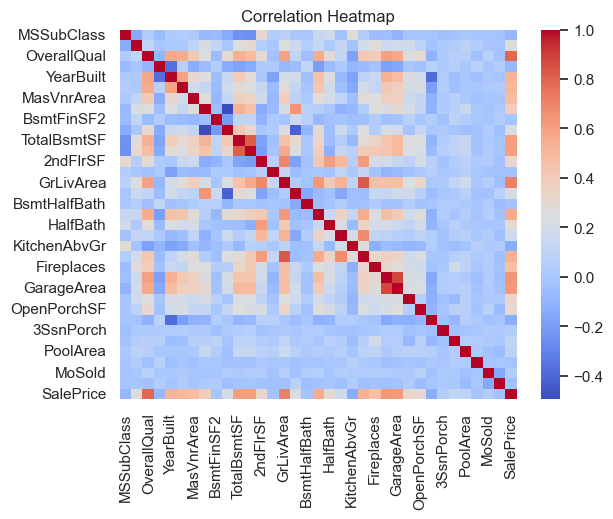

In [7]:
# Preprocess non-numeric data
obj_data = train.select_dtypes(include='object')
label_encoder = LabelEncoder()
obj_data_encoded = obj_data.apply(label_encoder.fit_transform)

# Select numerical data excluding the 'Id' column
num_data = train.select_dtypes(include='number')

# Concatenate numerical and encoded categorical data
data_cleaned = pd.concat([num_data, obj_data_encoded], axis=1)
data_cleaned.sort_index(axis=1, inplace=True)

# Plot the heatmap of the correlation matrix
sns.heatmap(num_data.corr(), cmap='coolwarm')

# Display the plot
plt.title('Correlation Heatmap')
plt.show()


#### There are some variables that show a significant correlation with the SalePrice we want to predict, both positively and negatively. Now, we should also examine the distributions of these numerical features.

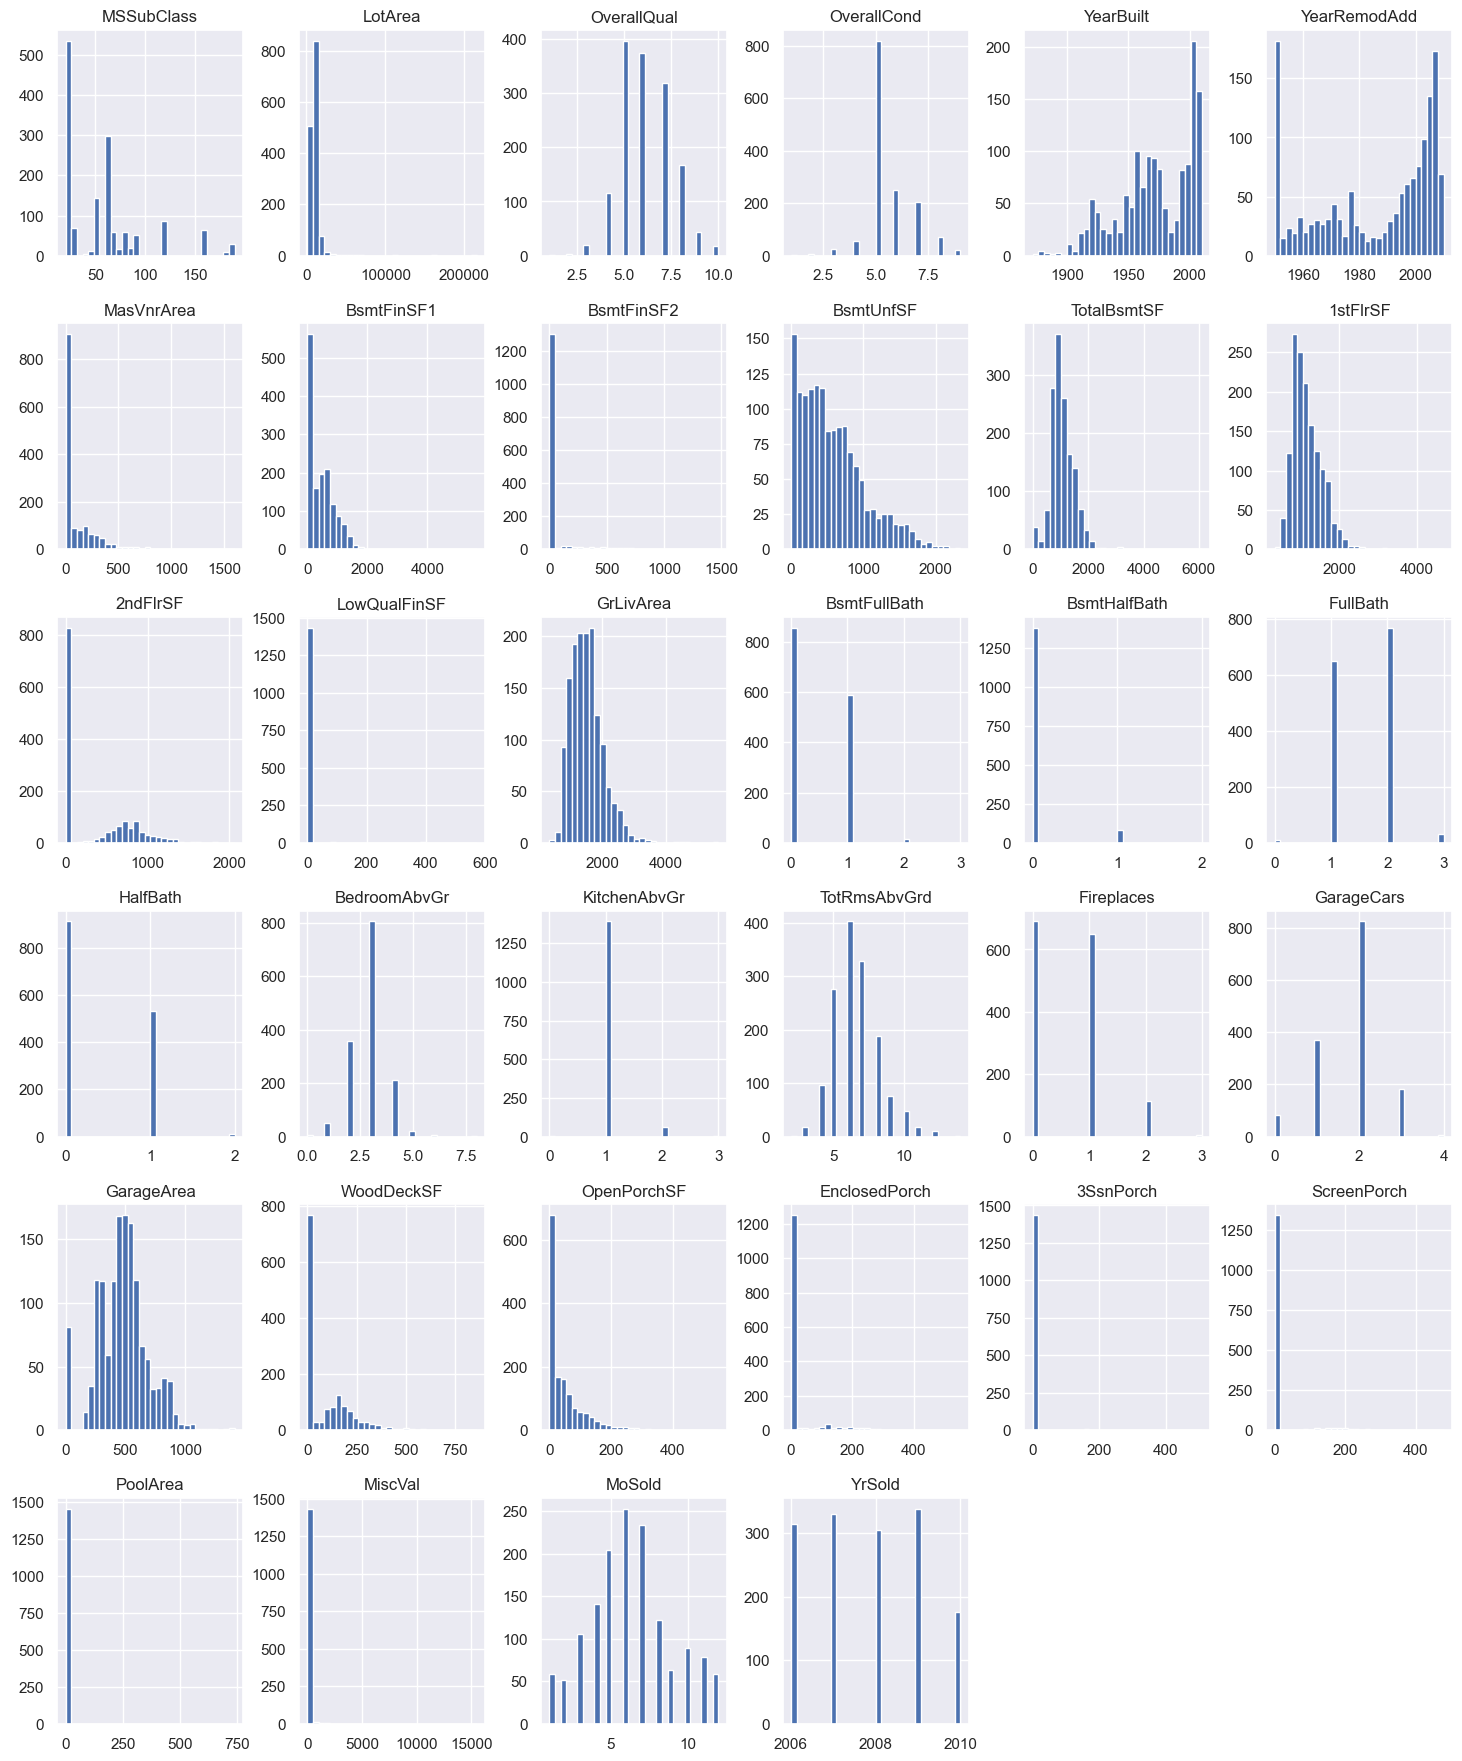

In [8]:
# Exclude 'SalePrice' column and plot histogram
num_data.drop('SalePrice', axis=1).hist(figsize=(18, 22), bins=30)

# Add labels and title to the plot
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Numerical Data')

# Display the plot
plt.show()

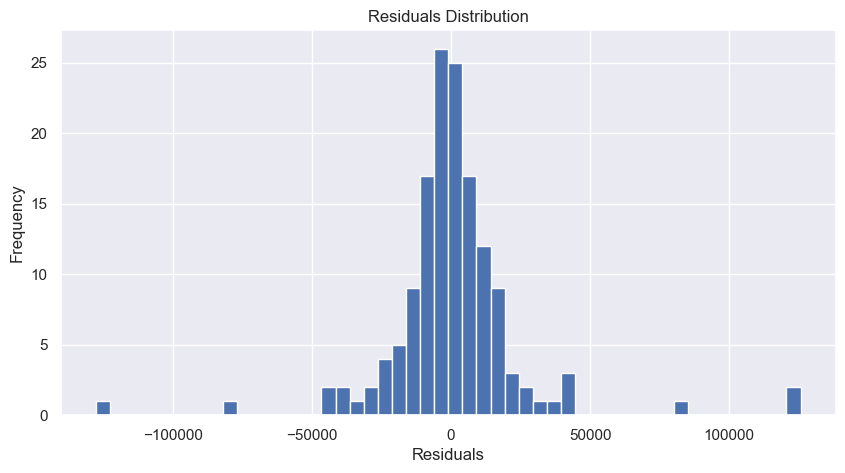

R-squared score: 0.9301551502052342
Root Mean Squared Error (RMSE): 25261.57625123124


In [9]:
# Split the dataset into training and testing sets
X = data_cleaned.drop('SalePrice', axis=1).fillna(data_cleaned.mean())
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the GradientBoostingRegressor model
gbr = GradientBoostingRegressor(n_estimators=300, max_depth=5, criterion='squared_error', learning_rate=0.1, random_state=42)
gbr.fit(X_train, y_train)

# Make predictions on the testing set
predictions = gbr.predict(X_test)

# Calculate residuals and plot a histogram
residuals = y_test - predictions
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Calculate and print the R-squared score and Root Mean Squared Error (RMSE)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
print("R-squared score:", r2)
print("Root Mean Squared Error (RMSE):", rmse)

In [10]:
# Select numerical columns from the test dataset and fill missing values with column means
validation_cleaned = validation.drop('Id', axis=1)
obj_columns = validation_cleaned.select_dtypes(include='object').columns

for col in obj_columns:
    label_encoder.fit(obj_data[col])
    validation_cleaned[col] = validation_cleaned[col].fillna(obj_data[col].mode().values[0])
    validation_cleaned[col] = label_encoder.transform(validation_cleaned[col])

validation_cleaned = validation_cleaned.fillna(validation_cleaned.mean())
validation_cleaned.sort_index(axis=1, inplace=True)

# Make predictions on the test dataset
sample_predictions = gbr.predict(validation_cleaned)

# Create a submission DataFrame with Id and SalePrice columns
sample_submission = pd.DataFrame({'Id': validation['Id'], 'SalePrice': sample_predictions})

# Save the submission DataFrame to a CSV file
sample_submission.to_csv('sample_submission.csv', index=False)


### Kaggle score: 0.13479
### Best 30% in the competition